<a href="https://colab.research.google.com/github/shihab1/Group-A-DLI-Assignment/blob/main/GNN(Shehab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# In a single cell
%pip uninstall -y torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv

# Reinstall the CUDA 12.4 + torch 2.6 wheels with NO CACHE
%pip install --no-cache-dir \
  torch-scatter==2.1.2+pt26cu124 \
  torch-sparse==0.6.18+pt26cu124 \
  torch-cluster==1.6.3+pt26cu124 \
  torch-spline-conv==1.2.2+pt26cu124 \
  -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

%pip install --no-cache-dir --force-reinstall torch-geometric==2.6.1

# Force a clean runtime restart (Colab/Jupyter)
import os, sys
os.kill(os.getpid(), 9)

Found existing installation: torch-geometric 2.6.1
Uninstalling torch-geometric-2.6.1:
  Successfully uninstalled torch-geometric-2.6.1
Found existing installation: torch_scatter 2.1.2+pt26cu124
Uninstalling torch_scatter-2.1.2+pt26cu124:
  Successfully uninstalled torch_scatter-2.1.2+pt26cu124
Found existing installation: torch_sparse 0.6.18+pt26cu124
Uninstalling torch_sparse-0.6.18+pt26cu124:
  Successfully uninstalled torch_sparse-0.6.18+pt26cu124
Found existing installation: torch_cluster 1.6.3+pt26cu124
Uninstalling torch_cluster-1.6.3+pt26cu124:
  Successfully uninstalled torch_cluster-1.6.3+pt26cu124
Found existing installation: torch_spline_conv 1.2.2+pt26cu124
Uninstalling torch_spline_conv-1.2.2+pt26cu124:
  Successfully uninstalled torch_spline_conv-1.2.2+pt26cu124
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 157.2 MB

In [23]:
%load_ext autoreload
%autoreload 2
import os
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

import sys
sys.path.append('/content')

from ag_utils import Corpus, parse_ag_file, parse_node_properties
from synthetic_data import gene_dataset
from models import NN, GCN, GAT, GCN_EW
from model_utils import train, predict_prob, evaluate_performance


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# parse attack graph file generated by MulVAL tool
attack_graph_path = '/content/AttackGraph.dot'
nodes, edges, node_properties = parse_ag_file(attack_graph_path)
node_dict = parse_node_properties(nodes, node_properties)

# save node label into corpus object
corpus = Corpus(node_dict)
num_tokens = corpus.get_num_tokens()
node_features = corpus.get_node_features()
node_types = corpus.get_node_types()
vocab_size = len(corpus.dictionary)
print('vocab_size: ', vocab_size)
print('num_tokens: ', num_tokens)
print('node_features shape: ', node_features.shape)

vocab_size:  57
num_tokens:  118
node_features shape:  torch.Size([26, 57])


In [3]:
# statistics of the encoded attack graph
num_nodes = len(nodes)
print('num_nodes: ', num_nodes)

num_node_features = node_features.shape[1]
print('num_node_features: ', num_node_features)

num_edges = len(edges)
print('num_edges: ', num_edges)

action_nodes = corpus.get_action_nodes()
action_node_idx = list(action_nodes.keys())
num_action_nodes = len(action_node_idx)
print('action_node_idx: ', action_node_idx)
print('num_action_nodes: ', num_action_nodes)

# var 'action_mask' is for representing the attack scenarios in attack graph (i.e., the privilege nodes)
action_mask = action_node_idx

num_nodes:  26
num_node_features:  57
num_edges:  26
action_node_idx:  [0, 2, 4, 7, 9, 12, 14]
num_action_nodes:  7


In [4]:
# adj matrix and edge index
adj_matrix = torch.zeros(len(nodes), len(nodes))

for edge in edges:
    source_node, target_node = edge
    source_index = nodes.index(source_node)
    target_index = nodes.index(target_node)
    adj_matrix[source_index][target_index] = 1

edge_index = adj_matrix.nonzero().t().contiguous()

assert edge_index.shape[0]==2

In [5]:
# prepare Dataset 1
num_benign = 1500
num_malic = 500
rt_meas_dim = 78
sample_method = 'synthetic'

X, Y = gene_dataset(num_benign, num_malic, num_nodes, action_nodes, rt_meas_dim)
num_samples = X.shape[0]

# rescale the data with min-max scaler
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X.view(-1, rt_meas_dim))
X = torch.from_numpy(X).float().view(num_samples, num_nodes, rt_meas_dim)

# associate node features in attack graph with real-time measurements
node_feat_ts = torch.stack([node_features for _ in range(len(X))], dim=0)
X = torch.cat((node_feat_ts, X), dim=2)

# split the data into training, validation and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42, stratify=Y_train)
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

torch.Size([3000, 26, 135]) torch.Size([3000, 7]) torch.Size([1000, 26, 135]) torch.Size([1000, 7]) torch.Size([1000, 26, 135]) torch.Size([1000, 7])


In [6]:
# load Dataset 1 used in the paper
data_path = '/content/datasets/'
X_train = torch.load(data_path+'X_train-{}.pth'.format(sample_method))
X_val   = torch.load(data_path+'X_val-{}.pth'.format(sample_method))
X_test  = torch.load(data_path+'X_test-{}.pth'.format(sample_method))
Y_train = torch.load(data_path+'Y_train-{}.pth'.format(sample_method))
Y_val   = torch.load(data_path+'Y_val-{}.pth'.format(sample_method))
Y_test  = torch.load(data_path+'Y_test-{}.pth'.format(sample_method))
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

torch.Size([3000, 26, 135]) torch.Size([3000, 7]) torch.Size([1000, 26, 135]) torch.Size([1000, 7]) torch.Size([1000, 26, 135]) torch.Size([1000, 7])


In [19]:
# hyperparameters for training
in_dim = X_train.shape[-1]  # Use the actual input dim
hidden_dim = 20
out_dim = 1
lr = 0.001
device = 'cpu'

# Model initialization (only NN)
model_NN = NN(in_dim, hidden_dim, out_dim)  # <-- use in_dim, not rt_meas_dim
model_NN.name = 'NN'
model_NN.action_mask = action_mask

num_epochs = 200  # Approximate early stopping point in paper

print(f'{model_NN.name} start training...')
time_start = time.time()
print('model: ', model_NN)

train(model_NN, lr, num_epochs, X_train, Y_train, X_val, Y_val, edge_index, in_dim, device)

time_end = time.time()
print('time cost: ', time_end - time_start)
print(f'{model_NN.name} training finished!')

print(f'{model_NN.name} accuracy on training set: {model_NN.stat["acc_train"][-1]}')
print(f'{model_NN.name} accuracy on validation set: {model_NN.stat["acc_val"][-1]}')

NN start training...
model:  NN(
  (lin1): Linear(in_features=135, out_features=20, bias=True)
  (lin2): Linear(in_features=20, out_features=20, bias=True)
  (out_layer): Linear(in_features=20, out_features=1, bias=True)
)
Epoch: 010, Training Loss: 0.5147, Traning Accuracy: 0.8631, Validation Loss: 0.5413, Validation Accuracy: 0.8614
Epoch: 020, Training Loss: 0.3809, Traning Accuracy: 0.9010, Validation Loss: 0.4188, Validation Accuracy: 0.8997
Epoch: 030, Training Loss: 0.3104, Traning Accuracy: 0.9260, Validation Loss: 0.3519, Validation Accuracy: 0.9230
Epoch: 040, Training Loss: 0.2775, Traning Accuracy: 0.9373, Validation Loss: 0.3361, Validation Accuracy: 0.9326
Epoch: 050, Training Loss: 0.2504, Traning Accuracy: 0.9461, Validation Loss: 0.3224, Validation Accuracy: 0.9396
Epoch: 060, Training Loss: 0.2291, Traning Accuracy: 0.9508, Validation Loss: 0.3172, Validation Accuracy: 0.9450
Epoch: 070, Training Loss: 0.2163, Traning Accuracy: 0.9538, Validation Loss: 0.3179, Validat

In [20]:
import torch
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

@torch.no_grad()
def evaluate_trained_nn(model, X_test, Y_test, device='cpu', threshold=0.5):
    model.eval()
    model.to(device)
    X_test = X_test.to(device)
    Y_test = Y_test.to(device)

    # Forward pass
    logits = model(X_test)  # (B, N) or (B, N, 1)
    if logits.ndim == 3 and logits.size(-1) == 1:
        logits = logits.squeeze(-1)

    # Indices of vulnerable nodes (list)
    idx = torch.as_tensor(model.action_mask, dtype=torch.long, device=device)

    # Align node dimension between logits and labels
    N_logits = logits.shape[1]
    N_labels = Y_test.shape[1]

    if N_logits == N_labels:
        # Both are full graphs -> index both
        logits_sel = logits.index_select(1, idx)
        Y_sel     = Y_test.index_select(1, idx)
    elif N_labels == idx.numel() and N_logits > N_labels:
        # Labels already masked to vulnerable nodes -> only index logits
        logits_sel = logits.index_select(1, idx)
        Y_sel     = Y_test
    elif N_logits == idx.numel() and N_labels > N_logits:
        # Logits already masked (rare) -> only index labels
        logits_sel = logits
        Y_sel     = Y_test.index_select(1, idx)
    else:
        raise ValueError(
            f"Mismatch: logits nodes={N_logits}, labels nodes={N_labels}, "
            f"indices={idx.numel()}. Can't align automatically."
        )

    # Probabilities & predictions
    probs = torch.sigmoid(logits_sel).detach().cpu().numpy().ravel()
    y_true = Y_sel.detach().cpu().numpy().astype(int).ravel()
    preds = (probs >= threshold).astype(int)

    # Metrics (micro/pooled)
    TP = int(((preds == 1) & (y_true == 1)).sum())
    FP = int(((preds == 1) & (y_true == 0)).sum())
    TN = int(((preds == 0) & (y_true == 0)).sum())
    FN = int(((preds == 0) & (y_true == 1)).sum())

    precision = TP / (TP + FP + 1e-12)
    recall    = TP / (TP + FN + 1e-12)
    f1        = 2 * precision * recall / (precision + recall + 1e-12)
    fpr       = FP / (FP + TN + 1e-12)
    fnr       = FN / (FN + TP + 1e-12)
    auc       = roc_auc_score(y_true, probs) if len(np.unique(y_true)) == 2 else float('nan')

    # Paper-style DataFrame
    return pd.DataFrame([{
        'Model': 'NN',
        'Precision': round(precision * 100, 2),
        'Recall':    round(recall * 100, 2),
        'F1-score':  round(f1 * 100, 2),
        'AUC':       round(auc * 100, 2),
        'FPR':       round(fpr * 100, 2),
        'FNR':       round(fnr * 100, 2),
        'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN
    }])

# ---- Usage after training ----
df_nn = evaluate_trained_nn(model_NN, X_test, Y_test, device=device, threshold=0.5)
print(df_nn)


  Model  Precision  Recall  F1-score    AUC   FPR   FNR   TP   FP    TN  FN
0    NN      68.82   95.86     80.12  98.83  4.83  4.14  671  304  5996  29


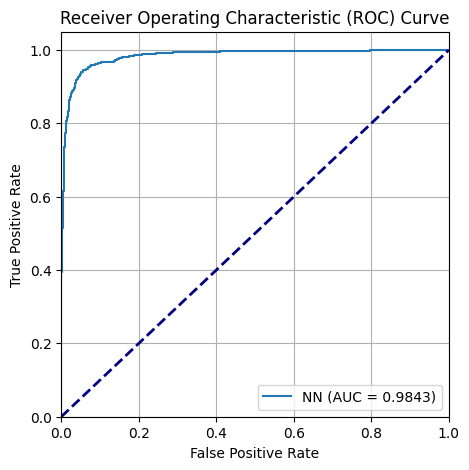

In [21]:
# plot the roc curve
from sklearn.metrics import roc_curve, auc
fig, ax = plt.subplots(figsize=(5, 5))
for name, model in models.items():
    prob = predict_prob(model, X_test, edge_index)
    y_probs = prob.view(-1, 2)

    fpr, tpr, thresholds = roc_curve(Y_test.view(-1), y_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, label='{} (AUC = {:.4f})'.format(model.name, roc_auc))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax.legend(loc="lower right")
ax.grid()
plt.show()

In [27]:
from torch_geometric.data import Data
from torch_geometric.explain import GNNExplainer, Explainer

# individual case analysis
found = False
while not found:
    indi_case_id = torch.randint(0, X_test.shape[0], (1,)).item()
    y_true = Y_test[indi_case_id]
    if y_true.sum() != 0:
        found = True
        print('indi_case_id: ', indi_case_id)

indi_case_x = X_test[indi_case_id]
indi_case_x = indi_case_x.unsqueeze(0)

indi_case_id:  555
